In [17]:
import os
import lmdb
import numpy as np
import torch
from torch.utils.data import Dataset
import numpy as np
from tqdm import tqdm
import lmdb
import umap
import matplotlib
matplotlib.use("module://matplotlib_inline.backend_inline")

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.preprocessing import RobustScaler
from sklearn.mixture import BayesianGaussianMixture


In [18]:
# LMDB values are stored in a custom binary format that includes a dtype string header.
DTYPE_MAP = {
    "float32": np.float32,
    "float64": np.float64,
    "int64": np.int64,
    "int32": np.int32,
    "int16": np.int16,
    "uint8": np.uint8,
}

# define process safe LMDB wrapper
class _PIDLMDB:
    """
    PyTorch DataLoader(num_workers > 0) uses multiple processes.
    When a process is forked/spawned, you don’t want to share an
    LMDB environment handle across processes. That can cause
    subtle errors or bad performance.
    """

    def __init__(self, path: str):
        self.path = path
        self._env = None
        self._pid = None

    def _get_env(self):
        # get process id and check if we need to reopen the LMDB environment
        pid = os.getpid()
        # If the environment is not initialized or the process has changed, open a new environment
        if self._env is None or self._pid != pid:
            self._env = lmdb.open(
                self.path,
                readonly=True,
                lock=False,
                readahead=False,
                subdir=True,
                max_readers=4096,
            )
            # store the current process id to detect future changes
            self._pid = pid
        # return the LMDB environment for the current process
        return self._env

    def get_key(self, key: bytes):
        # get the LMDB environment for the current process and retrieve the value for the given key
        env = self._get_env()
        # use a read-only transaction to get the value for the key, which is a bytes object containing the encoded array
        with env.begin(write=False, buffers=True) as txn:
            # return the value for the key, or None if the key does not exist
            return txn.get(key)

    def get(self, idx: int) -> bytes:
        """Fetch by integer id (encoded to bytes)."""
        return self.get_key(str(idx).encode("utf-8"))

    def has(self, idx: int) -> bool:
        """True if integer id exists in LMDB."""
        return self.get_key(str(idx).encode("utf-8")) is not None


class HSQCDataset(Dataset):
    def __init__(
        self,
        dataset_root="/data",
        split="train",
        normalize_intensity=True,
    ):
        # path to LMDB: {dataset_root}/_lmdb/{split}/HSQC_NMR.lmdb
        self.dataset_root = dataset_root
        self.split = split
        self.normalize_intensity = normalize_intensity

        self.hsqc_lmdb = _PIDLMDB(
            os.path.join(dataset_root, "_lmdb", split, "HSQC_NMR.lmdb")
        )

        # --- prefetch keys for faster access ---
        env = self.hsqc_lmdb._get_env()
        with env.begin(write=False) as txn:
            self.keys = []
            for k, _ in txn.cursor():
                s = k.decode("utf-8")
                if s.isdigit():
                    self.keys.append(k)

    def _decode_array(self,buf) -> np.ndarray:
        # c memoryview for zero-copy access, then decode header and data
        mv = memoryview(buf)
        # The header format is: "{dtype}|{ndim}|{shape}|", e.g. "float32|2|128,3|"
        b = mv.tobytes()
        # Find the positions of the '|' delimiters to parse the header
        first = b.index(b"|")
        second = b.index(b"|", first + 1)
        third = b.index(b"|", second + 1)
        # Extract dtype, ndim, and shape from the header
        dtype_str = b[:first].decode("ascii")
        ndim = int(b[first + 1 : second].decode("ascii"))
        shape_str = b[second + 1 : third].decode("ascii")
        # Convert shape string to a tuple of ints, e.g. "128,3" -> (128, 3)
        shape = (
            tuple(int(x) for x in shape_str.split(",")) if ndim > 0 and shape_str else ()
        )
        # dtype map and create numpy array from the remaining buffer
        dt = DTYPE_MAP[dtype_str]
        arr = np.frombuffer(mv[third + 1 :], dtype=dt)
        # reshape if needed
        if shape:
            arr = arr.reshape(shape)
        return arr

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, row_idx):
        #  --- DataLoader gives i in [0, len(keys)-1] ---
        # bytes key from LMDB, e.g. b"123"
        key = self.keys[row_idx]
        # get the binary buffer for the key from LMDB, which contains the encoded array
        hsqc_buf = self.hsqc_lmdb.get_key(key)
        # decode the key to get the integer index, e.g. b"123" -> 123
        idx = int(key.decode("utf-8"))
        if hsqc_buf is None:
            raise KeyError(f"Missing LMDB key idx={idx}")
        # decode the binary buffer into a numpy array of shape (N, 3) with dtype float32
        hsqc = self._decode_array(hsqc_buf).astype(np.float32, copy=False)  # (N,3)

        # --- intensity transform as a data invariant ---
        if self.normalize_intensity:
            # signed intensity transform: I -> sign(I) * log(1 + abs(I))
            I = hsqc[:, 2]
            hsqc[:, 2] = np.sign(I) * np.log1p(np.abs(I))

        hsqc = torch.from_numpy(hsqc.copy())
        
        return idx, hsqc

In [19]:
ds = HSQCDataset(dataset_root="/data", split="train", normalize_intensity=True)
print("len:", len(ds))

idx, hsqc = ds[0]
print("idx:", idx)
print("hsqc:", hsqc.shape, hsqc.dtype)
print(hsqc[:5])


len: 109694
idx: 0
hsqc: torch.Size([21, 3]) torch.float32
tensor([[54.8900,  3.0770, -0.6931],
        [54.8900,  3.4800, -0.6931],
        [37.0500,  2.7100,  0.6931],
        [26.9500,  2.0800,  0.6931],
        [24.2400,  2.2300, -0.6931]])


In [20]:
def collate_hsqc(batch):
    # batch is a list of (idx, hsqc_tensor)
    idxs, hsqcs = zip(*batch)
    return torch.tensor(idxs, dtype=torch.int64), list(hsqcs)

def collate_flatten_peaks(batch):
    idxs, hsqcs = zip(*batch)

    # Keep track of which molecule each peak came from (optional but useful)
    mol_index = []
    all_peaks = []

    for j, peaks in enumerate(hsqcs):
        n = peaks.shape[0]
        all_peaks.append(peaks)
        mol_index.append(torch.full((n,), j, dtype=torch.int64))

    X = torch.cat(all_peaks, dim=0)                 # (sum_i Ni, 3)
    mol_index = torch.cat(mol_index, dim=0)         # (sum_i Ni,)
    idxs = torch.tensor(idxs, dtype=torch.int64)    # (B,)

    return idxs, X, mol_index


loader = DataLoader(
    ds,
    batch_size=64,          # molecules per batch
    shuffle=True,           # fine for clustering sampling
    num_workers=0,          # start with 0 for debugging; bump later
    pin_memory=False,       # for CPU clustering doesn't matter
    collate_fn=collate_flatten_peaks,
)

In [21]:

def sample_peaks(loader, max_peaks=200_000):
    Xs = []
    n = 0
    for batch in loader:
        # works for your flatten collate: (idxs, X, mol_index)
        idxs, X, mol_index = batch
        if X.numel() == 0:
            continue
        Xs.append(X.cpu().numpy())
        n += X.shape[0]
        if n >= max_peaks:
            break
    X = np.concatenate(Xs, axis=0)[:max_peaks]
    return X

X = sample_peaks(loader, max_peaks=200_000)
print("X shape:", X.shape)
print("C range:", X[:,0].min(), X[:,0].max())
print("H range:", X[:,1].min(), X[:,1].max())
print("I range:", X[:,2].min(), X[:,2].max())




X shape: (200000, 3)
C range: -5.13 209.8
H range: -0.6758597 10.9176
I range: -13.120999 12.270946


In [22]:
scaler = RobustScaler(quantile_range=(5, 95))
Xn = scaler.fit_transform(X)

bgmm = BayesianGaussianMixture(
    n_components=100,  # overspecify
    covariance_type="full",
    weight_concentration_prior_type="dirichlet_process",
    weight_concentration_prior=1e-2,
    max_iter=500,
    init_params="kmeans",
    random_state=0,
)

N_fit = 50_000
X_fit = Xn[np.random.choice(Xn.shape[0], N_fit, replace=False)]
bgmm.fit(X_fit)

active = (bgmm.weights_ > 1e-3).sum()
print("Active clusters ~", active)
print("Top weights:", np.sort(bgmm.weights_)[-10:])

P = bgmm.predict_proba(Xn)     # (N, K)
labels = P.argmax(axis=1)     # hard label for plotting
conf = P.max(axis=1)          # confidence
print("mean confidence:", conf.mean())


Active clusters ~ 31
Top weights: [0.03323937 0.03860183 0.04385101 0.05014099 0.05641836 0.05790746
 0.057983   0.07963747 0.09450116 0.19104284]
mean confidence: 0.8833962033400344


In [25]:
emb = umap.UMAP(
    n_neighbors=30, # 30 is too local, 100 is more global and seems to separate clusters better
    min_dist=0.1, #
    random_state=0
).fit_transform(Xn)

/workspace/.pixi/envs/default/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


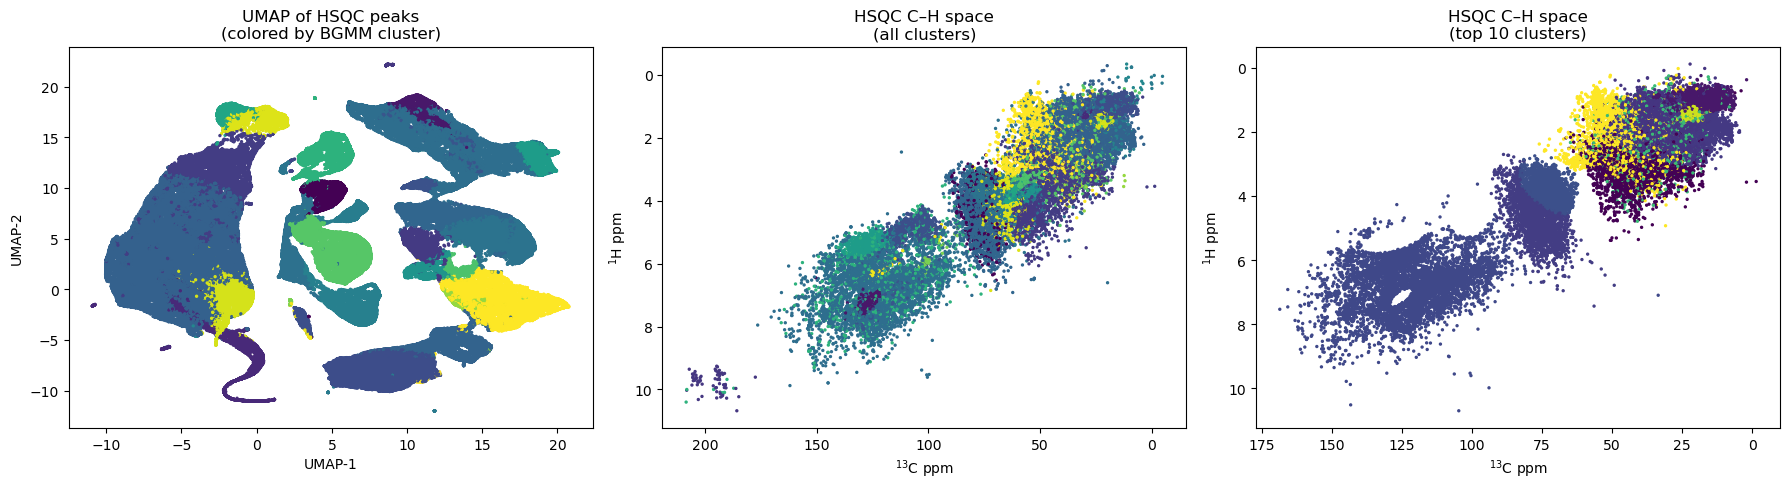

In [26]:
%matplotlib inline

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# --------- Panel 1: UMAP ---------
axes[0].scatter(
    emb[:, 0],
    emb[:, 1],
    s=2,
    c=labels,
)
axes[0].set_title("UMAP of HSQC peaks\n(colored by BGMM cluster)")
axes[0].set_xlabel("UMAP-1")
axes[0].set_ylabel("UMAP-2")

# --------- Panel 2: All HSQC peaks in C–H space ---------
N = 50_000
idx_all = np.random.choice(X.shape[0], N, replace=False)

axes[1].scatter(
    X[idx_all, 0],
    X[idx_all, 1],
    s=2,
    c=labels[idx_all],
)
axes[1].set_title("HSQC C–H space\n(all clusters)")
axes[1].set_xlabel(r"$^{13}$C ppm")
axes[1].set_ylabel(r"$^{1}$H ppm")
axes[1].invert_xaxis()  # NMR convention
axes[1].invert_yaxis()

# --------- Panel 3: Top clusters only ---------
active_ids = np.where(bgmm.weights_ > 1e-3)[0]
top_ids = active_ids[np.argsort(-bgmm.weights_[active_ids])[:10]]

mask = np.isin(labels, top_ids)
idx_top = np.random.choice(
    np.where(mask)[0],
    min(50_000, mask.sum()),
    replace=False,
)

axes[2].scatter(
    X[idx_top, 0],
    X[idx_top, 1],
    s=2,
    c=labels[idx_top],
)
axes[2].set_title("HSQC C–H space\n(top 10 clusters)")
axes[2].set_xlabel(r"$^{13}$C ppm")
axes[2].set_ylabel(r"$^{1}$H ppm")
axes[2].invert_xaxis()
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()
